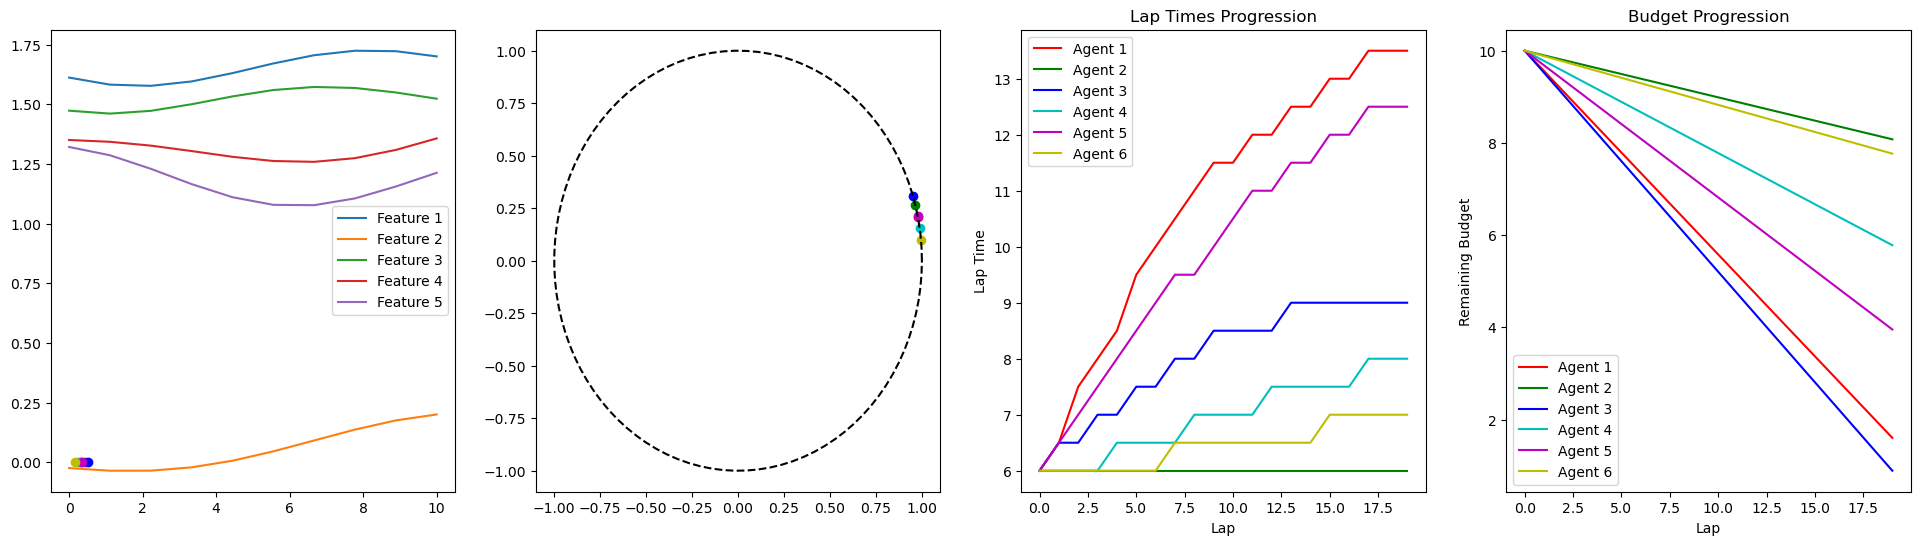

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Initialize global variables for history and best states
last_successful_feature = None
last_successful_perturbation = None
last_best_agent_state = None
last_best_lap_time = None

# # Initialize agent with budget
# def initialize_agent_with_budget(n, budget, seed = 42):
#     if seed is not None:
#         np.random.seed(seed)
#     agent = np.random.randn(n)
#     return agent, budget

# # Hill climb optimization for each agent
# def optimize_agent(agent, lap_time, prev_lap_time, budget, delta=0.1):
#     if lap_time < prev_lap_time and budget > 0:
#         perturbation = np.random.uniform(-delta, delta)
#         feature_to_change = np.random.randint(0, len(agent))
#         agent[feature_to_change] += perturbation
#         budget -= np.abs(perturbation)
#     return agent, max(budget, 0)

# Fourier-based track feature generator
def generate_fourier(L, n, N=5, kappa=0.03): # L: length of track, n: number of features, N: number of frequencies, kappa: small for smooth track
    x = np.linspace(0, 1, L)
    track = np.zeros((L, n))
    
    # Generate frequencies and scales based on kappa
    freqs = [kappa * (i + 1) for i in range(N)]
    scales = [kappa * 0.5 * (i + 1) for i in range(N)]
    
    for j in range(n):
        A0 = np.random.randn()
        track[:, j] += A0
        
        for i in range(1, N + 1):
            An = np.random.randn() * scales[i-1]
            Bn = np.random.randn() * scales[i-1]
            freq = freqs[i-1]
            
            track[:, j] += An * np.cos(2 * np.pi * freq * i * x) + Bn * np.sin(2 * np.pi * freq * i * x)
            
    return track

# Initialize agent features
def initialize_agent(n, seed = 42):
    if seed is not None:
        np.random.seed(seed)
    return np.random.randn(n)

# Compute speed
def speed(agent, track_features, alpha=1.0, beta=1.0):
    norm_agent = np.linalg.norm(agent)
    norm_track = np.linalg.norm(track_features)
    return alpha + beta * np.dot(agent, track_features) / (norm_agent * norm_track)

# Main function for simulation
def main(num_agents=3, num_laps=10, initial_budget=1.0):
    L, n, alpha, beta, dt = 10, 5, 1.0, 1.0, 0.5
    
    global last_successful_feature, last_successful_perturbation, last_best_agent_state, last_best_lap_time
    last_successful_feature = np.zeros(num_agents, dtype=int)
    last_successful_perturbation = np.zeros(num_agents)
    last_best_agent_state = [np.zeros(n) for _ in range(num_agents)]
    last_best_lap_time = np.inf * np.ones(num_agents)
    
    
    track = generate_fourier(L, n)
    agents = [initialize_agent(n) for _ in range(num_agents)]
    budgets = np.ones(num_agents) * initial_budget

    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    prev_lap_times = np.inf * np.ones(num_agents)

    def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                        last_successful_feature, last_successful_perturbation,
                        budget, agent_idx, delta=0.5, min_improvement=0.05):
        
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')
        
        if lap_time < last_best_lap_time[agent_idx] - min_improvement:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time
            
            # Random perturbation
            perturbation = np.random.uniform(-delta, delta)
            feature_to_change = np.random.randint(0, len(agent))
            
            if budget - np.abs(perturbation) >= 0:
                agent[feature_to_change] += perturbation
                budget -= np.abs(perturbation)
                
                last_successful_feature[agent_idx] = feature_to_change
                last_successful_perturbation[agent_idx] = perturbation
                
        else:
            feature_to_change = last_successful_feature[agent_idx]
            perturbation = last_successful_perturbation[agent_idx]
            
            if feature_to_change is not None and perturbation != 0 and budget - np.abs(perturbation) >= 0:
                agent[feature_to_change] += perturbation
                budget -= np.abs(perturbation)
            else:
                agent = np.copy(last_best_agent_state[agent_idx])
                last_successful_feature[agent_idx] = None
                last_successful_perturbation[agent_idx] = 0

        return agent, max(budget, 0)



    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    
    # Plot features
    for i in range(n):
        ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
    ax1.legend()
    
    points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
    
    for lap in range(num_laps):
        positions = np.zeros(num_agents)  # Reset for a new lap
        lap_times = np.zeros(num_agents)

        while np.any(positions < L):
            for i in range(num_agents):
                if positions[i] >= L:
                    continue  # Skip agents that have finished the lap
                agent = agents[i]
                s = positions[i]
                track_features = track[int(s) % L]
                v = speed(agent, track_features, alpha, beta)
                positions[i] += v * dt
                lap_times[i] += dt
                
                # Update visualization
                points[i].set_data(positions[i] % L, 0)
                theta = 2 * np.pi * (positions[i] % L) / L
                circles[i].set_data(np.cos(theta), np.sin(theta))

            clear_output(wait=True)
            display(fig)
            plt.pause(0.01)
        
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets

        # Optimize agents based on lap times
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, last_successful_feature, last_successful_perturbation, budgets[i], i, delta=0.5, min_improvement=0.05)
            # optimize_agent(agents[i], lap_times[i], prev_lap_times[i], budgets[i], i, delta=0.5, min_improvement=0.05, last_best_agent_state=last_best_agent_state, last_successful_feature=last_successful_feature, last_successful_perturbation=last_successful_perturbation)

        prev_lap_times = lap_times

        # Plot lap times history
        ax3.clear()
        for i in range(num_agents):
            ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax3.legend()
        ax3.set_title('Lap Times Progression')
        ax3.set_xlabel('Lap')
        ax3.set_ylabel('Lap Time')

        # Plot budget history
        ax4.clear()
        for i in range(num_agents):
            ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax4.legend()
        ax4.set_title('Budget Progression')
        ax4.set_xlabel('Lap')
        ax4.set_ylabel('Remaining Budget')

main(num_agents=6, num_laps=50, initial_budget=10.0)

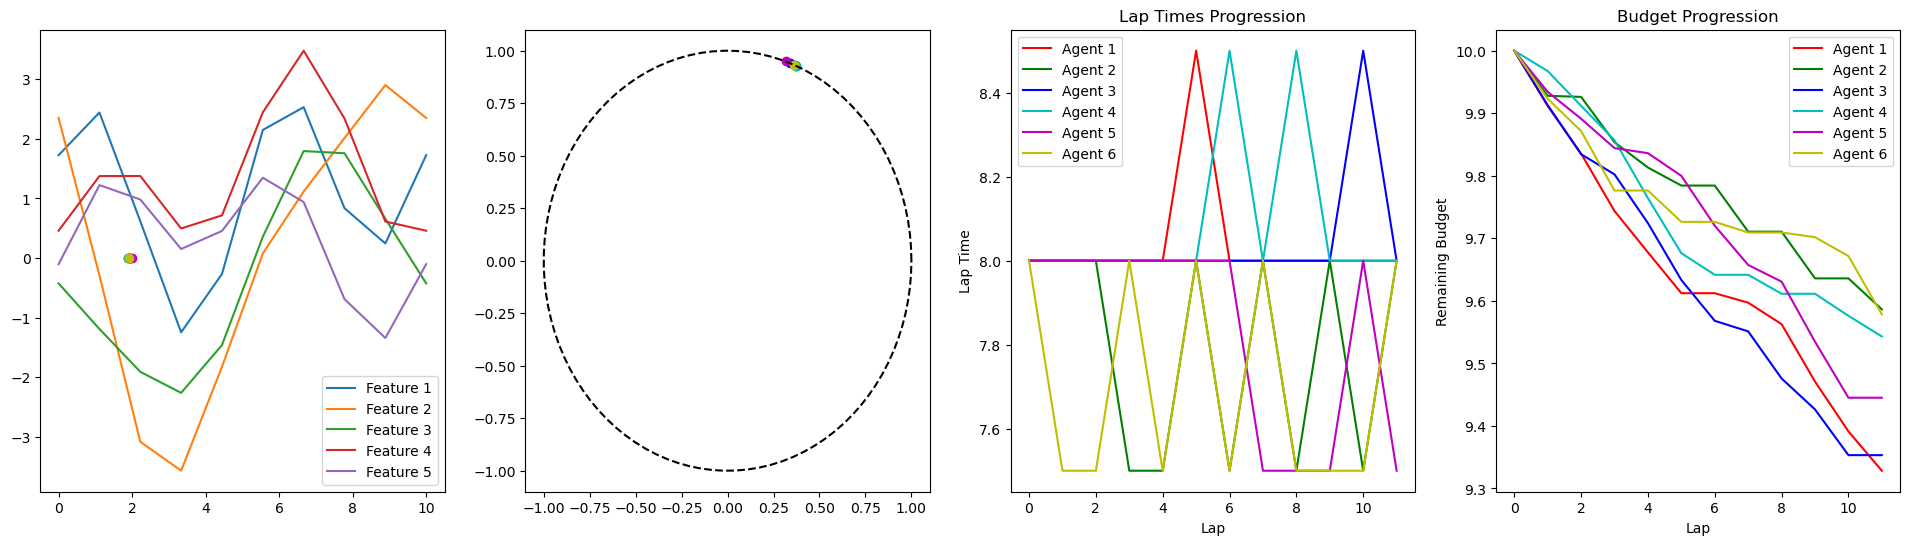

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Initialize global variables for history and best states
last_successful_feature = None
last_successful_perturbation = None
last_best_agent_state = None
last_best_lap_time = None

# # Initialize agent with budget
# def initialize_agent_with_budget(n, budget, seed = 42):
#     if seed is not None:
#         np.random.seed(seed)
#     agent = np.random.randn(n)
#     return agent, budget

# # Hill climb optimization for each agent
# def optimize_agent(agent, lap_time, prev_lap_time, budget, delta=0.1):
#     if lap_time < prev_lap_time and budget > 0:
#         perturbation = np.random.uniform(-delta, delta)
#         feature_to_change = np.random.randint(0, len(agent))
#         agent[feature_to_change] += perturbation
#         budget -= np.abs(perturbation)
#     return agent, max(budget, 0)

# Fourier-based track feature generator
# def generate_fourier(L, n, N=5, kappa=0.03): # L: length of track, n: number of features, N: number of frequencies, kappa: small for smooth track
#     x = np.linspace(0, 1, L)
#     track = np.zeros((L, n))
    
#     # Generate frequencies and scales based on kappa
#     freqs = [kappa * (i + 1) for i in range(N)]
#     scales = [kappa * 0.5 * (i + 1) for i in range(N)]
    
#     for j in range(n):
#         A0 = np.random.randn()
#         track[:, j] += A0
        
#         for i in range(1, N + 1):
#             An = np.random.randn() * scales[i-1]
#             Bn = np.random.randn() * scales[i-1]
#             freq = freqs[i-1]
            
#             track[:, j] += An * np.cos(2 * np.pi * freq * i * x) + Bn * np.sin(2 * np.pi * freq * i * x)
            
#     return track
def generate_fourier(L, n, N=10, kappa=0.25): # L: length of track, n: number of features, N: number of frequencies, kappa: small for smooth track
    x = np.linspace(0, 1, L)
    track = np.zeros((L, n))

    # Highest frequency based on kappa
    highest_frequency = int(N * kappa)
    
    for j in range(n):
        A0 = np.random.randn()  
        track[:, j] += A0
        
        for i in range(1, highest_frequency + 1):  # Loop up to the highest frequency
            An = np.random.randn()
            Bn = np.random.randn()
            
            track[:, j] += An * np.cos(2 * np.pi * i * x) + Bn * np.sin(2 * np.pi * i * x)
            
    return track

# Initialize agent features
def initialize_agent(n, seed = 42):
    if seed is not None:
        np.random.seed(seed)
    return np.random.randn(n)

# Compute speed
def speed(agent, track_features, alpha=1.0, beta=1.0):
    norm_agent = np.linalg.norm(agent)
    norm_track = np.linalg.norm(track_features)
    return alpha + beta * np.dot(agent, track_features) / (norm_agent * norm_track)

# Main function for simulation
def main(num_agents=3, num_laps=10, initial_budget=1.0):
    L, n, alpha, beta, dt = 10, 5, 1.0, 1.0, 0.5
    
    global last_successful_feature, last_successful_perturbation, last_best_agent_state, last_best_lap_time
    last_successful_feature = np.zeros(num_agents, dtype=int)
    last_successful_perturbation = np.zeros(num_agents)
    last_best_agent_state = [np.zeros(n) for _ in range(num_agents)]
    last_best_lap_time = np.inf * np.ones(num_agents)
    
    
    track = generate_fourier(L, n)
    agents = [initialize_agent(n) for _ in range(num_agents)]
    budgets = np.ones(num_agents) * initial_budget

    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    prev_lap_times = np.inf * np.ones(num_agents)

    def rotate_features(agent, theta, u, v):
        """Rotates agent's features in the plane defined by vectors u and v."""
        I = np.identity(len(agent))
        rotation_matrix = (I + (np.cos(theta) - 1) * (np.outer(u, u) + np.outer(v, v)) +
                        np.sin(theta) * (np.outer(u, v) - np.outer(v, u)))
        return np.dot(rotation_matrix, agent)

    def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                    budget, agent_idx, min_improvement=0.05, rotation_scale=0.1):
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')

        if lap_time <= last_best_lap_time[agent_idx]:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time

            # Generate random rotation angle and basis vectors
            theta = np.random.uniform(-rotation_scale, rotation_scale)
            u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
            u /= np.linalg.norm(u)
            v /= np.linalg.norm(v)

            # Rotate features
            agent = rotate_features(agent, theta, u, v)
            budget -= np.abs(theta)
        else:
            # Roll back to the best-known state if no improvement
            agent = np.copy(last_best_agent_state[agent_idx])

        return agent, budget




    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    
    # Plot features
    for i in range(n):
        ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
    ax1.legend()
    
    points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
    ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
    
    for lap in range(num_laps):
        positions = np.zeros(num_agents)  # Reset for a new lap
        lap_times = np.zeros(num_agents)

        while np.any(positions < L):
            for i in range(num_agents):
                if positions[i] >= L:
                    continue  # Skip agents that have finished the lap
                agent = agents[i]
                s = positions[i]
                track_features = track[int(s) % L]
                v = speed(agent, track_features, alpha, beta)
                positions[i] += v * dt
                lap_times[i] += dt
                
                # Update visualization
                points[i].set_data(positions[i] % L, 0)
                theta = 2 * np.pi * (positions[i] % L) / L
                circles[i].set_data(np.cos(theta), np.sin(theta))

            clear_output(wait=True)
            display(fig)
            plt.pause(0.01)
        
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets

        # Optimize agents based on lap times
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, budgets[i], i, min_improvement=0.05)
                # agents[i], lap_times[i], last_best_lap_time, last_best_agent_state, last_successful_feature, last_successful_perturbation, budgets[i], i, min_improvement=0.05)
            # optimize_agent(agents[i], lap_times[i], prev_lap_times[i], budgets[i], i, delta=0.5, min_improvement=0.05, last_best_agent_state=last_best_agent_state, last_successful_feature=last_successful_feature, last_successful_perturbation=last_successful_perturbation)

        prev_lap_times = lap_times

        # Plot lap times history
        ax3.clear()
        for i in range(num_agents):
            ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax3.legend()
        ax3.set_title('Lap Times Progression')
        ax3.set_xlabel('Lap')
        ax3.set_ylabel('Lap Time')

        # Plot budget history
        ax4.clear()
        for i in range(num_agents):
            ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        ax4.legend()
        ax4.set_title('Budget Progression')
        ax4.set_xlabel('Lap')
        ax4.set_ylabel('Remaining Budget')

main(num_agents=6, num_laps=50, initial_budget=10.0)